<a href="https://colab.research.google.com/github/OscarJDiaz/Computacion_Inteligente/blob/main/YoloV4/Mask_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este proyecto se pretende utilizar google colaboratory y darknet con yolo v4 para que sea capaz de detectar si una persona esta o no esta llevando una mascarilla.

Darknet es un marco de red neuronal de código abierto escrito en C y CUDA. Es rápido, fácil de instalar y admite el cálculo de CPU y GPU.
Podemos utilizar Darknet y yolo v4 (You only look once), el cual es un sistema de deteccion de objetos a tiempo real. Lo obtendremos a traves de este github (https://github.com/AlexeyAB/darknet.git)

Utilizaremos el google drive y un dataset, de kaggle, de imagenes de caras con y sin máscarillas el cual ya pose el etiquetado utilizado por yolo (donde se indica los tipos que aparecen en la imagen y donde se encuentran (https://www.kaggle.com/aditya276/face-mask-dataset-yolo-format)

In [1]:
# Cargamos nuestro drive en el notebook de trabajo
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Nos aseguramos de usar GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
%cd /content/gdrive/My Drive/darknet

/content/gdrive/My Drive/darknet


In [ ]:
# Descargamos garknet, copiando el contenido del github y guardandolo en el drive
%cd /content/gdrive/My Drive
!git clone 'https://github.com/AlexeyAB/darknet.git' '/content/gdrive/My Drive/darknet'
%cd /content/gdrive/My Drive/darknet
!ls

/content/gdrive/My Drive
fatal: destination path '/content/gdrive/My Drive/darknet' already exists and is not an empty directory.
/content/gdrive/My Drive/darknet
3rdparty	DarknetConfig.cmake.in	include		       results
backup		darknet_images.py	json_mjpeg_streams.sh  scripts
build		darknet.py		LICENSE		       src
build.ps1	darknet_video.py	Makefile	       vcpkg.json
cfg		data			net_cam_v3.sh	       video_yolov3.sh
cmake		images			net_cam_v4.sh	       video_yolov4.sh
CMakeLists.txt	image_yolov3.sh		obj
darknet		image_yolov4.sh		README.md


In [4]:
#Configuración del archivo Makefile, que define un conjunto de tareas a ejecutar
#Le pedirmeos que utilice openCV y la GPU
%%writefile Makefile
GPU=1
CUDNN=1
CUDNN_HALF=1
OPENCV=1
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0
ZED_CAMERA_v2_8=0

# set GPU=1 and CUDNN=1 to speedup on GPU
# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher
# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)
# set ZED_CAMERA=1 to enable ZED SDK 3.0 and above
# set ZED_CAMERA_v2_8=1 to enable ZED SDK 2.X

USE_CPP=0
DEBUG=0

ARCH= -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52] \
	    -gencode arch=compute_61,code=[sm_61,compute_61]

OS := $(shell uname)

# GeForce RTX 3070, 3080, 3090
# ARCH= -gencode arch=compute_86,code=[sm_86,compute_86]

# Kepler GeForce GTX 770, GTX 760, GT 740
# ARCH= -gencode arch=compute_30,code=sm_30

# Tesla A100 (GA100), DGX-A100, RTX 3080
# ARCH= -gencode arch=compute_80,code=[sm_80,compute_80]

# Tesla V100
# ARCH= -gencode arch=compute_70,code=[sm_70,compute_70]

# GeForce RTX 2080 Ti, RTX 2080, RTX 2070, Quadro RTX 8000, Quadro RTX 6000, Quadro RTX 5000, Tesla T4, XNOR Tensor Cores
# ARCH= -gencode arch=compute_75,code=[sm_75,compute_75]

# Jetson XAVIER
# ARCH= -gencode arch=compute_72,code=[sm_72,compute_72]

# GTX 1080, GTX 1070, GTX 1060, GTX 1050, GTX 1030, Titan Xp, Tesla P40, Tesla P4
# ARCH= -gencode arch=compute_61,code=sm_61 -gencode arch=compute_61,code=compute_61

# GP100/Tesla P100 - DGX-1
# ARCH= -gencode arch=compute_60,code=sm_60

# For Jetson TX1, Tegra X1, DRIVE CX, DRIVE PX - uncomment:
# ARCH= -gencode arch=compute_53,code=[sm_53,compute_53]

# For Jetson Tx2 or Drive-PX2 uncomment:
# ARCH= -gencode arch=compute_62,code=[sm_62,compute_62]

# For Tesla GA10x cards, RTX 3090, RTX 3080, RTX 3070, RTX A6000, RTX A40 uncomment:
# ARCH= -gencode arch=compute_86,code=[sm_86,compute_86]


VPATH=./src/
EXEC=darknet
OBJDIR=./obj/

ifeq ($(LIBSO), 1)
LIBNAMESO=libdarknet.so
APPNAMESO=uselib
endif

ifeq ($(USE_CPP), 1)
CC=g++
else
CC=gcc
endif

CPP=g++ -std=c++11
NVCC=nvcc
OPTS=-Ofast
LDFLAGS= -lm -pthread
COMMON= -Iinclude/ -I3rdparty/stb/include
CFLAGS=-Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC

ifeq ($(DEBUG), 1)
#OPTS= -O0 -g
#OPTS= -Og -g
COMMON+= -DDEBUG
CFLAGS+= -DDEBUG
else
ifeq ($(AVX), 1)
CFLAGS+= -ffp-contract=fast -mavx -mavx2 -msse3 -msse4.1 -msse4.2 -msse4a
endif
endif

CFLAGS+=$(OPTS)

ifneq (,$(findstring MSYS_NT,$(OS)))
LDFLAGS+=-lws2_32
endif

ifeq ($(OPENCV), 1)
COMMON+= -DOPENCV
CFLAGS+= -DOPENCV
LDFLAGS+= `pkg-config --libs opencv4 2> /dev/null || pkg-config --libs opencv`
COMMON+= `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv`
endif

ifeq ($(OPENMP), 1)
    ifeq ($(OS),Darwin) #MAC
	    CFLAGS+= -Xpreprocessor -fopenmp
	else
		CFLAGS+= -fopenmp
	endif
LDFLAGS+= -lgomp
endif

ifeq ($(GPU), 1)
COMMON+= -DGPU -I/usr/local/cuda/include/
CFLAGS+= -DGPU
ifeq ($(OS),Darwin) #MAC
LDFLAGS+= -L/usr/local/cuda/lib -lcuda -lcudart -lcublas -lcurand
else
LDFLAGS+= -L/usr/local/cuda/lib64 -lcuda -lcudart -lcublas -lcurand
endif
endif

ifeq ($(CUDNN), 1)
COMMON+= -DCUDNN
ifeq ($(OS),Darwin) #MAC
CFLAGS+= -DCUDNN -I/usr/local/cuda/include
LDFLAGS+= -L/usr/local/cuda/lib -lcudnn
else
CFLAGS+= -DCUDNN -I/usr/local/cudnn/include
LDFLAGS+= -L/usr/local/cudnn/lib64 -lcudnn
endif
endif

ifeq ($(CUDNN_HALF), 1)
COMMON+= -DCUDNN_HALF
CFLAGS+= -DCUDNN_HALF
ARCH+= -gencode arch=compute_70,code=[sm_70,compute_70]
endif

ifeq ($(ZED_CAMERA), 1)
CFLAGS+= -DZED_STEREO -I/usr/local/zed/include
ifeq ($(ZED_CAMERA_v2_8), 1)
LDFLAGS+= -L/usr/local/zed/lib -lsl_core -lsl_input -lsl_zed
#-lstdc++ -D_GLIBCXX_USE_CXX11_ABI=0
else
LDFLAGS+= -L/usr/local/zed/lib -lsl_zed
#-lstdc++ -D_GLIBCXX_USE_CXX11_ABI=0
endif
endif

OBJ=image_opencv.o http_stream.o gemm.o utils.o dark_cuda.o convolutional_layer.o list.o image.o activations.o im2col.o col2im.o blas.o crop_layer.o dropout_layer.o maxpool_layer.o softmax_layer.o data.o matrix.o network.o connected_layer.o cost_layer.o parser.o option_list.o darknet.o detection_layer.o captcha.o route_layer.o writing.o box.o nightmare.o normalization_layer.o avgpool_layer.o coco.o dice.o yolo.o detector.o layer.o compare.o classifier.o local_layer.o swag.o shortcut_layer.o representation_layer.o activation_layer.o rnn_layer.o gru_layer.o rnn.o rnn_vid.o crnn_layer.o demo.o tag.o cifar.o go.o batchnorm_layer.o art.o region_layer.o reorg_layer.o reorg_old_layer.o super.o voxel.o tree.o yolo_layer.o gaussian_yolo_layer.o upsample_layer.o lstm_layer.o conv_lstm_layer.o scale_channels_layer.o sam_layer.o
ifeq ($(GPU), 1)
LDFLAGS+= -lstdc++
OBJ+=convolutional_kernels.o activation_kernels.o im2col_kernels.o col2im_kernels.o blas_kernels.o crop_layer_kernels.o dropout_layer_kernels.o maxpool_layer_kernels.o network_kernels.o avgpool_layer_kernels.o
endif

OBJS = $(addprefix $(OBJDIR), $(OBJ))
DEPS = $(wildcard src/*.h) Makefile include/darknet.h

all: $(OBJDIR) backup results setchmod $(EXEC) $(LIBNAMESO) $(APPNAMESO)

ifeq ($(LIBSO), 1)
CFLAGS+= -fPIC

$(LIBNAMESO): $(OBJDIR) $(OBJS) include/yolo_v2_class.hpp src/yolo_v2_class.cpp
	$(CPP) -shared -std=c++11 -fvisibility=hidden -DLIB_EXPORTS $(COMMON) $(CFLAGS) $(OBJS) src/yolo_v2_class.cpp -o $@ $(LDFLAGS)

$(APPNAMESO): $(LIBNAMESO) include/yolo_v2_class.hpp src/yolo_console_dll.cpp
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) -o $@ src/yolo_console_dll.cpp $(LDFLAGS) -L ./ -l:$(LIBNAMESO)
endif

$(EXEC): $(OBJS)
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) $^ -o $@ $(LDFLAGS)

$(OBJDIR)%.o: %.c $(DEPS)
	$(CC) $(COMMON) $(CFLAGS) -c $< -o $@

$(OBJDIR)%.o: %.cpp $(DEPS)
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) -c $< -o $@

$(OBJDIR)%.o: %.cu $(DEPS)
	$(NVCC) $(ARCH) $(COMMON) --compiler-options "$(CFLAGS)" -c $< -o $@

$(OBJDIR):
	mkdir -p $(OBJDIR)
backup:
	mkdir -p backup
results:
	mkdir -p results
setchmod:
	chmod +x *.sh

.PHONY: clean

clean:
	rm -rf $(OBJS) $(EXEC) $(LIBNAMESO) $(APPNAMESO)


Overwriting Makefile


In [5]:
#Ejecutamos el archivo para reakizar los cambios
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_opencv

In [ ]:
# Nuestro dataset ya viene con la direcciones de las imagenes
# (/darknet/images/train.txt). Por esta razon guardamos el dataset del kaggle
# dentro de la carpeta darknet

!cp -r "/content/gdrive/My Drive/Colab Notebooks/datasets/mask_yolo/images" "/content/gdrive/My Drive/darknet"
!ls

3rdparty	DarknetConfig.cmake.in	include		       results
backup		darknet_images.py	json_mjpeg_streams.sh  scripts
build		darknet.py		LICENSE		       src
build.ps1	darknet_video.py	Makefile	       vcpkg.json
cfg		data			net_cam_v3.sh	       video_yolov3.sh
cmake		images			net_cam_v4.sh	       video_yolov4.sh
CMakeLists.txt	image_yolov3.sh		obj
darknet		image_yolov4.sh		README.md


Ahora realizaremos unas modificaciones a los archivos del dataset para que encagen más con el formato estandar de yolo

In [ ]:
# Creamos dos carpetas:
# Una llamada "backup" donde se almacenaran los pesos del entrenamiento.
# Otra llamada "custom_weight" donde pondremos los pesos descargados que usaremos
# para entrenar.

from os import mkdir
%cd /content/gdrive/My Drive/darknet/images
mkdir("backup");
mkdir("custom_weight");

/content/gdrive/My Drive/darknet/images


In [ ]:
#Cambiar el tipo de archivo classes de .txt a .names
from pathlib import Path
p = Path('classes.txt')
p.rename(p.with_suffix('.names'))

In [ ]:
#Creamos el archivo obj.data que dice las direcciones de los archivos para el entrenamiento
#En caso de que exista el archivo obj.data, que lo quite.
import os
if os.path.exists('/content/gdrive/My Drive/darknet/data/obj.data'): os.remove('/content/gdrive/My Drive/darknet/data/obj.data')
with open('/content/gdrive/My Drive/darknet/data/obj.data', 'w') as out:
  out.write('classes = 2\n')
  out.write('train = /content/gdrive/My Drive/darknet/images/train.txt\n')
  out.write('valid = /content/gdrive/My Drive/darknet/images/valid.txt\n')
  out.write('names = /content/gdrive/My Drive/darknet/images/classes.names\n')
  out.write('backup = /content/gdrive/My Drive/darknet/images/backup/')

Debido a problemas con el google colaboratory por el tamaño del dataset utilizaremos yoloV4-tini, una red yolo más pequeñas con menos combolucionades.
De esta forma se reduce el tiempo del entrenamiento y se siguen obteniendo 
buenos resultados

Se pondra en la carpeta "custom_weight" los pesos del 'yolov4-tiny.conv.29' y en la carpeta "/darket/cfg/" se colocara el archivo 'yolo-obj.cfg' donde esta escrita la estructura de la red. 

El archivo 'yolo-obj.cfg' se le descomenta el training y se inidica:
batch=64 

subdivisions=32 

max_batches = 4000 (numero de clases * 2000) 

steps=3200,3600 (80% y 90% del max_batches) 

y en todas las seciones de [Yolo] y la combolucionada previa indicar:

filters=21 (numero de clase + 5)x3

classes=2


Estos archivos se encuentran subidos al github

In [ ]:
# Aseguramos que estamos en el directorio y ejecutamos el siguiente comando para
# iniciar el entrenamiento de la red

%cd /content/gdrive/My Drive/darknet
!./darknet detector train data/obj.data cfg/yolo-obj.cfg images/custom_weight/yolov4-tiny.conv.29 -dont_show -map

Se han truncado las últimas 5000 líneas del flujo de salida.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.748531), count: 3, class_loss = 0.274903, iou_loss = 0.207149, total_loss = 0.482052 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.797036), count: 13, class_loss = 0.901422, iou_loss = 12.195971, total_loss = 13.097392 
 total_bbox = 1129779, rewritten_bbox = 0.793252 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.807188), count: 4, class_loss = 0.059806, iou_loss = 0.534743, total_loss = 0.594549 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.781130), count: 24, class_loss = 1.732486, iou_loss = 34.148693, total_loss = 35.881180 
 total_bbox = 1129807, rewritten_bbox = 0.793233 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.802710), count: 6, class_loss = 0.103929, iou_loss = 0.762540, total_loss =

Mascarilla  Mask  mask_yolo  Sign-Language  Sign-Language.zip


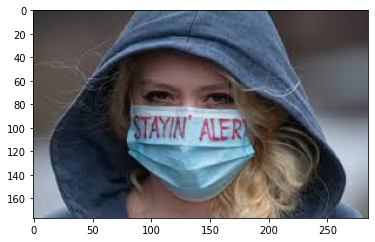

In [6]:
# Usamos matplotlib para comprobar que podemos mostrar imagenes

!ls "/content/gdrive/My Drive/Colab Notebooks/datasets/"
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/gdrive/My Drive/Colab Notebooks/datasets/mask_yolo/images/train/images18.jpg', 'r')
imshow(np.asarray(pil_im))

/content/gdrive/My Drive/darknet
 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x 

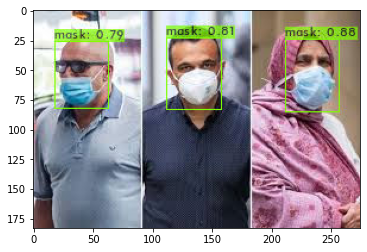

In [7]:
# Probar detector y mostrar imagen, la imagen se guarda en 
# /content/gdrive/My Drive/darknet/predictions.jpg

%cd /content/gdrive/My Drive/darknet
! ./darknet detect cfg/yolo-obj.cfg images/backup/yolo-obj_best.weights images/valid/images19.jpg -thresh 0.4 -dont-show -map
print('predictions.jpg')
pil_im = Image.open('/content/gdrive/My Drive/darknet/predictions.jpg', 'r')
imshow(np.asarray(pil_im))

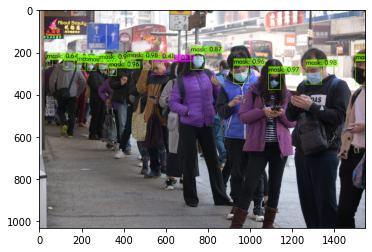

In [8]:
#Algunos resultados
Imagen = Image.open('/content/gdrive/My Drive/darknet/images/ImagenesDetectadas/predictions1.jpg', 'r')
imshow(np.asarray(Imagen))

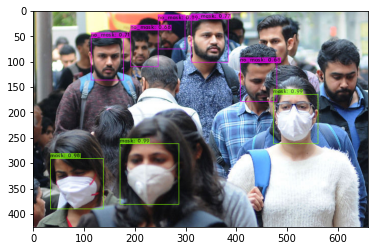

In [9]:
Imagen = Image.open('/content/gdrive/My Drive/darknet/images/ImagenesDetectadas/predictions2.jpg', 'r')
imshow(np.asarray(Imagen))

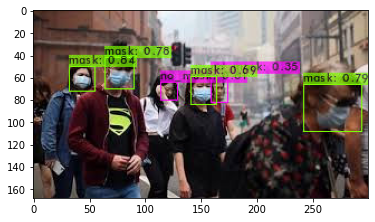

In [10]:
Imagen = Image.open('/content/gdrive/My Drive/darknet/images/ImagenesDetectadas/predictions3.jpg', 'r')
imshow(np.asarray(Imagen))

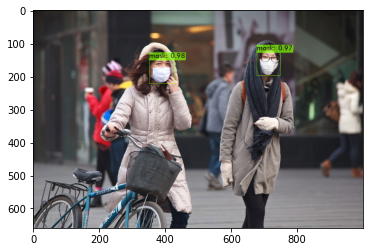

In [11]:
Imagen = Image.open('/content/gdrive/My Drive/darknet/images/ImagenesDetectadas/predictions4.jpg', 'r')
imshow(np.asarray(Imagen))